KL-Diversence 적용
- 코로나19 발생 이후, 업종들의 통상적인 시계열 특성이 많이 바꼈다. 그렇기때문에,지역별,업종별, 소비자 정보별 19년 소비 분포와 20년 소비 분포의 차이를 분석해 유사도를 뽑아보는 생각에 착안

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import gc

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy.spatial import distance
from math import log2
from math import sqrt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [3]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/train_df_noNAN.csv')
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/submission.csv')

In [4]:
data.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


우선 AMT 0 row를 만들기 위해 groupby() 문법을 활용하여 데이터 프레임을 새롭게 만들어 보자.

In [5]:
st_form = data.groupby(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC',])['AMT'].sum().reset_index().drop('AMT',axis=1).copy()

In [6]:
st_form['REG_YYMM'] = 201901
st_201901=st_form.copy()
st_201901 = st_201901.merge(data[data['REG_YYMM']==201901],
                            on=['REG_YYMM','CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'],
                            how='left')


for day in [201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003,202004,202007]:
  st_form['REG_YYMM'] = day
  st_day = st_form.copy()
  st_day = st_day.merge(data[data['REG_YYMM']==day],
                            on=['REG_YYMM','CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'],
                            how='left')
  st_201901 = pd.concat([st_201901,st_day])
  gc.collect()

st_all = st_201901.copy()

In [7]:
st_all.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,REG_YYMM,CSTMR_CNT,AMT,CNT
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,201901,4.0,311200.0,4.0
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,2,1,201901,NaN,NaN,NaN
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,201901,7.0,1374500.0,8.0
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,201901,6.0,818700.0,6.0
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,201901,4.0,1717000.0,5.0


In [8]:
st_all.shape

(59165355, 12)

In [9]:
# null 값 확인
st_all.isnull().sum()

CARD_SIDO_NM           0
CARD_CCG_NM            0
STD_CLSS_NM            0
HOM_SIDO_NM            0
HOM_CCG_NM             0
AGE                    0
SEX_CTGO_CD            0
FLC                    0
REG_YYMM               0
CSTMR_CNT       34467563
AMT             34467563
CNT             34467563
dtype: int64

In [10]:
# null 값 0 삽입
st_all.fillna(0,inplace=True)

In [11]:
# st_all.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/st_all.csv',encoding='utf-8-sig',index=False)

In [12]:
# train, test 쪼개기


train_df = st_all[(st_all['REG_YYMM'] != 202007)&(st_all['REG_YYMM'] != 202004)]
test_df = st_all[(st_all['REG_YYMM'] == 202007&(st_all['REG_YYMM'] == 202004))]
# train_df = st_all[st_all['REG_YYMM'] != 202007]
# test_df = st_all[st_all['REG_YYMM'] == 202007]

del st_all
gc.collect()

11

---

# Jensen-Shannon Divergence 

## 업종별 AMT 유사도

In [ ]:
job_amt= train_df.groupby(['REG_YYMM','CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'])['AMT'].sum().reset_index()

In [ ]:
amt_sum = job_amt.groupby(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'])['AMT'].sum().reset_index(name='AMT_sum')
job_amt = job_amt.merge(amt_sum,on=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],how='left')
job_amt['AMT_prob'] = job_amt['AMT']/job_amt['AMT_sum']

# pivot_table을 활용하여 long to wide 작업 실시
amt_pivot= pd.pivot_table(job_amt,
                          index=['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],
                          columns='REG_YYMM',
                          values='AMT_prob').reset_index()
amt_pivot.fillna(0,inplace=True)

In [ ]:
amt_array=np.array(amt_pivot.drop(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM'],axis=1))

job_similarity =[]
for row_r in range(amt_array.shape[0]):
    if row_r%100 ==0 and row_r !=0:
        print(row_r)
        
    dt_list=[]
    for row_c in range(amt_array.shape[0]):
        #dt= js_divergence(amt_pivot.iloc[row_r,3:].values,amt_pivot.iloc[row_c,3:].values)
        '''
        js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
        sqrt(js_divergence)인 distance.jensenshannon 함수 사용
        '''
        dt = distance.jensenshannon(amt_array[row_r,:],amt_array[row_c,:],2.0)
        dt_list.append(dt)
    job_similarity.append(dt_list)

similarity_frame =pd.DataFrame(np.array(job_similarity))
job_similarity = pd.concat([amt_pivot[['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM']],similarity_frame],axis=1)j

job_similarity.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/job_similarity.csv',encoding='utf-8-sig',index=False)

## 소비자별 AMT 유사도

In [ ]:
customer_amt= train_df.groupby(['REG_YYMM','HOM_SIDO_NM','HOM_CCG_NM','AGE', 'SEX_CTGO_CD','FLC'])['AMT'].sum().reset_index()

In [14]:
amt_sum = customer_amt.groupby(['HOM_SIDO_NM','HOM_CCG_NM','AGE', 'SEX_CTGO_CD','FLC'])['AMT'].sum().reset_index(name='AMT_sum')
customer_amt = customer_amt.merge(amt_sum,on=['HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'],how='left')
customer_amt['AMT_prob'] = customer_amt['AMT']/customer_amt['AMT_sum']
# pivot_table을 활용하여 long to wide 작업 실시
amt_pivot= pd.pivot_table(customer_amt,
                          index=['HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'],
                          columns='REG_YYMM',
                          values='AMT_prob').reset_index()
amt_pivot.fillna(0,inplace=True)

In [ ]:
#피벗된 연도별 amt를 사용해 고객간의 유사도를 구해보자.
amt_array=np.array(amt_pivot.drop(['HOM_SIDO_NM','HOM_CCG_NM','AGE', 'SEX_CTGO_CD','FLC'],axis=1))

customer_similarity =[]
for row_r in range(amt_array.shape[0]):
    if row_r%100 ==0 and row_r !=0:
        print(row_r)
        
    dt_list=[]
    for row_c in range(amt_array.shape[0]):
        #dt= js_divergence(amt_pivot.iloc[row_r,3:].values,amt_pivot.iloc[row_c,3:].values)
        '''
        js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
        sqrt(js_divergence)인 distance.jensenshannon 함수 사용
        '''
        dt = distance.jensenshannon(amt_array[row_r,:],amt_array[row_c,:],2.0)
        dt_list.append(dt)
    customer_similarity.append(dt_list)

customer_frame =pd.DataFrame(np.array(customer_similarity))
customer_similarity = pd.concat([amt_pivot,customer_frame],axis=1)

customer_similarity.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/customer_similarity.csv',encoding='utf-8-sig',index=False)

## 유사도 함수 만들기
- 업종별 AMT 유사도, 소비자별 AMT 유사도를 바탕으로 matrix를 구하는 함수 생성
- 이해가 안되면 위에 있는 두 가지의 유도 방법을 참고 바람

In [13]:
def Jensenshannon_similarity(df,input_list):
  '''
  [함수 사용법]
    REG_YYMM을 input_list 인덱싱 0번 자리(맨앞)에 둘 것
    그 뒤로 기준을 잡고 싶은 변수들을 차례로 넣어 주면 됩니다.
    from scipy.spatial import distance 꼭 할것!
  '''


  make_amt= df.groupby(input_list)['AMT'].sum().reset_index()
  
  '''pivot 만들기'''
  amt_sum = make_amt.groupby(input_list[1:])['AMT'].sum().reset_index(name='AMT_sum')
  make_amt = make_amt.merge(amt_sum,on=input_list[1:],how='left')
  make_amt['AMT_prob'] = make_amt['AMT']/make_amt['AMT_sum']

  # pivot_table을 활용하여 long to wide 작업 실시
  amt_pivot= pd.pivot_table(make_amt,
                            index=input_list[1:],
                            columns='REG_YYMM',
                            values='AMT_prob').reset_index()
  amt_pivot.fillna(0,inplace=True)

  #피벗된 연도별 amt를 사용해 고객간의 유사도를 구해보자.
  amt_array=np.array(amt_pivot.drop(input_list[1:],axis=1))

  js_similarity =[]
  for row_r in range(amt_array.shape[0]):       
    dt_list=[]
    for row_c in range(amt_array.shape[0]):
        #dt= js_divergence(amt_pivot.iloc[row_r,3:].values,amt_pivot.iloc[row_c,3:].values)
        '''
        js_divergence(만든 함수)로 하면 0값을 계산을 못함. 
        sqrt(js_divergence)인 distance.jensenshannon 함수 사용
        '''
        dt = distance.jensenshannon(amt_array[row_r,:],amt_array[row_c,:],2.0)
        dt_list.append(dt)
    js_similarity.append(dt_list)

  js_frame =pd.DataFrame(np.array(js_similarity))
  js_similarity = pd.concat([amt_pivot,js_frame],axis=1)

  return js_similarity

In [17]:
job_similarity= Jensenshannon_similarity(train_df,input_list=['REG_YYMM', 'CARD_SIDO_NM', 'CARD_CCG_NM', 'STD_CLSS_NM'])
customer_similarity= Jensenshannon_similarity(train_df,input_list=['REG_YYMM', 'HOM_SIDO_NM','HOM_CCG_NM','AGE','SEX_CTGO_CD','FLC'])

In [18]:
job_similarity.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/job_similarity.csv',encoding='utf-8-sig',index=False)
customer_similarity.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/customer_similarity.csv',encoding='utf-8-sig',index=False)

# Clustering
- 계층적 군집분석(상향식)

In [1]:
import pandas as pd

In [2]:
job_similarity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/job_similarity.csv')
customer_similarity = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/제주/customer_similarity.csv')

In [3]:
js=job_similarity.iloc[:,-job_similarity.shape[0]:]
cs=customer_similarity.iloc[:,-customer_similarity.shape[0]:]

In [139]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=int(js.shape[0]/2),
                                     affinity='precomputed',
                                     linkage='average')
clustering.fit(js)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=3887)

In [140]:
pd.Series(clustering.labels_).value_counts()

7       712
82      359
107     337
97      209
58      194
       ... 
1230      1
3275      1
1226      1
3271      1
2045      1
Length: 3887, dtype: int64

int(row/10) 로 n_clusters를 설정하자.

In [141]:
jsd = job_similarity.iloc[:,:-job_similarity.shape[0]]
jsd['cluster'] = clustering.labels_

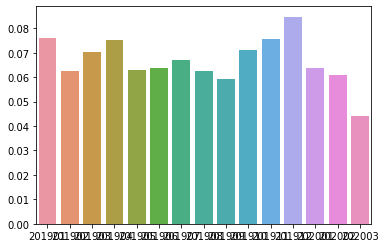

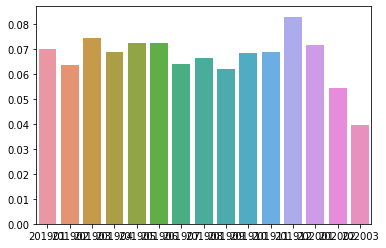

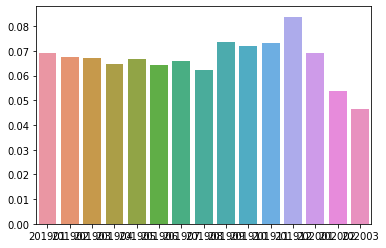

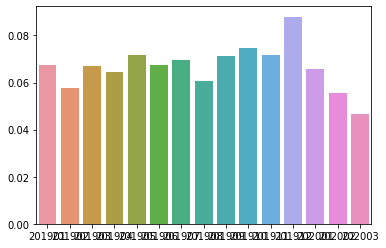

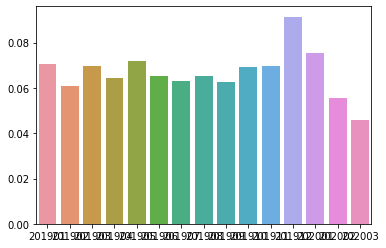

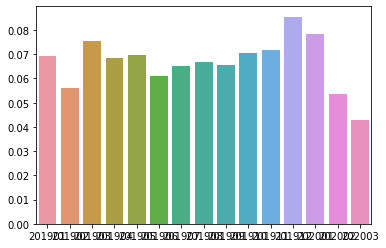

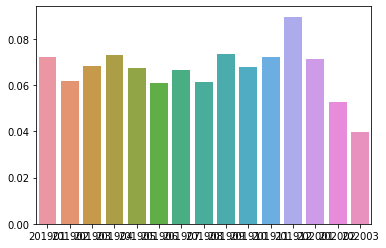

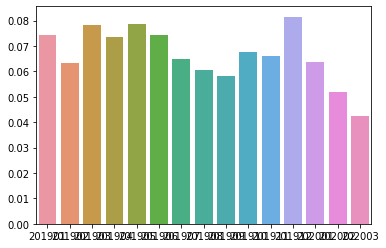

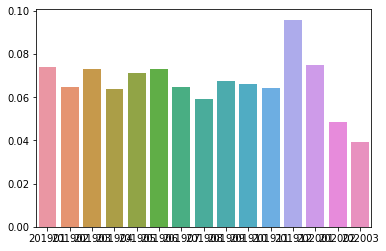

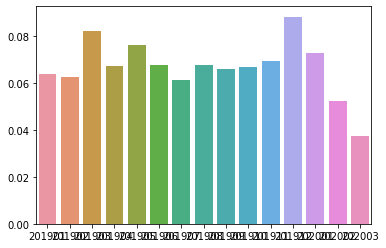

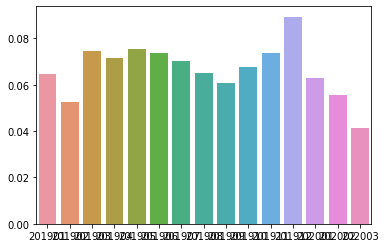

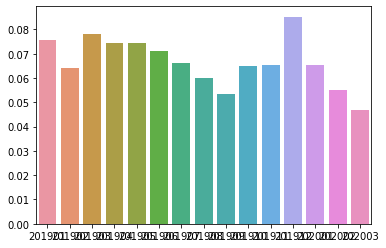

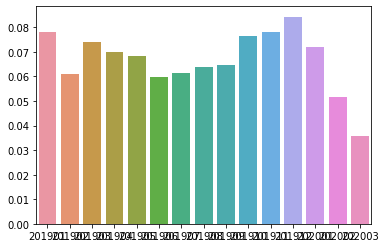

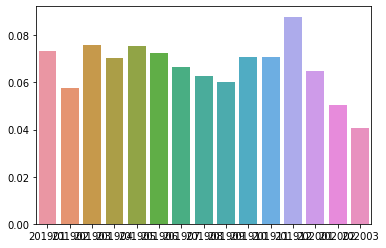

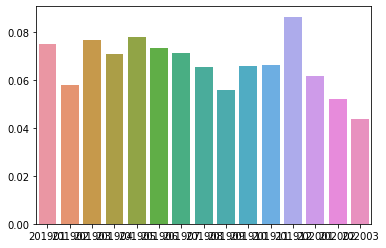

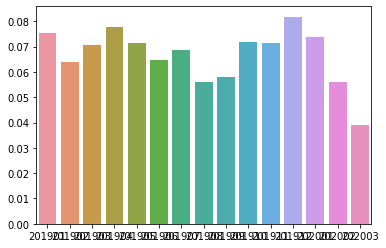

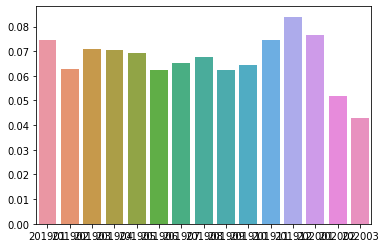

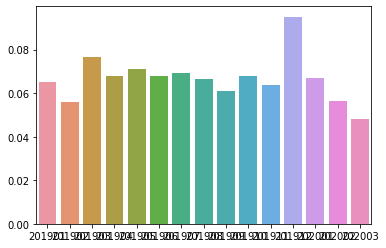

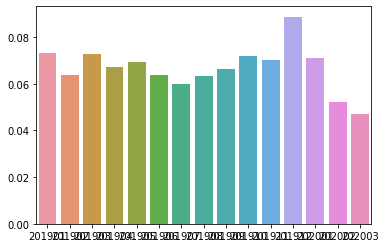

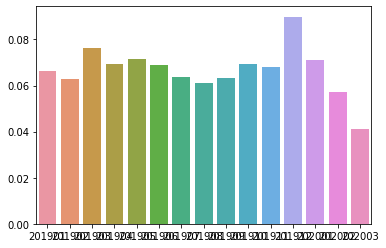

In [150]:
for col in jsd[jsd['cluster'] ==1].drop(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','cluster'],axis=1).T.columns:
  sns.barplot(x=jsd[jsd['cluster'] ==1].drop(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','cluster'],axis=1).T[col].index,
              y=jsd[jsd['cluster'] ==1].drop(['CARD_SIDO_NM','CARD_CCG_NM','STD_CLSS_NM','cluster'],axis=1).T[col].values)
  plt.show()

군집내의 row들의 분포만을 비교해보면 거의 유사한 것으로 보임.

## 클러스터링 함수 만들기


In [151]:
def make_clustering(df):
    df_s = df.iloc[:,-df.shape[0]:] # 클러스터링용 dataframe 생성
    clustering = AgglomerativeClustering(n_clusters=int(df_s.shape[0]/2),
                                     affinity='precomputed',
                                     linkage='average')
    clustering.fit(df_s)
    
    dfd = df.iloc[:,:-df.shape[0]]
    dfd['cluster'] = clustering.labels_
    
    return dfd.drop(dfd.iloc[:,-16:-1].columns,axis=1)

In [152]:
kk=make_clustering(job_similarity)
tt=make_clustering(customer_similarity)

In [153]:
kk.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,cluster
0,강원,강릉시,건강보조식품 소매업,2462
1,강원,강릉시,골프장 운영업,3495
2,강원,강릉시,과실 및 채소 소매업,2444
3,강원,강릉시,관광 민예품 및 선물용품 소매업,2747
4,강원,강릉시,그외 기타 스포츠시설 운영업,2711


In [154]:
tt.head()

,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,cluster
0,강원,강릉시,10s,1,1,1627
1,강원,강릉시,10s,2,1,1799
2,강원,강릉시,20s,1,1,40
3,강원,강릉시,20s,1,2,117
4,강원,강릉시,20s,2,1,167
